In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from config import Config
import utils
import glob #for selecting png files in training images folder
from natsort import natsorted, ns #for sorting filenames in a directory
import skimage
import pandas

import model as modellib
import visualize
from model import log

Using TensorFlow backend.


In [2]:
def resetDataDir():
    while os.getcwd() != "C:\\":
        os.chdir('..')

    # Replace the following with the entire path to your data
    os.chdir('C:\\Users\\dal4019\\Documents\\Bst_Reg')

# Root directory of the project
resetDataDir()
ROOT_DIR = os.getcwd()
print(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "weights")


C:\Users\dal4019\Documents\Bst_Reg


In [3]:
RGB_MAPPINGS_DIR = 'rgb_mappings_medulla_v2.csv'

resetDataDir()

RGB_MAPPINGS = pandas.read_csv(RGB_MAPPINGS_DIR, usecols = ['Label', 'R', 'G', 'B']).dropna()
RGB_MAPPINGS_MAP = {}
for index, row in RGB_MAPPINGS.iterrows():
    r = row["R"]
    g = row["G"]
    b = row["B"]
    label = row["Label"]
    RGB_MAPPINGS_MAP[label] =(r,g,b)
    
RGB_MAPPINGS_LABELS = list(RGB_MAPPINGS_MAP.keys())
RGB_MAPPINGS_INDEX = RGB_MAPPINGS.index.values
NUM_LABELS = len(RGB_MAPPINGS_INDEX)
print(NUM_LABELS)

25


## Load data to run detection

In [4]:
########### Create detection dataset:

class BrainDataset(utils.Dataset):
    """Generates the brain section dataset. The dataset consists of locally stored 
    brain section images, to which file access is required.
    """

    #see utils.py for default def load_image() function; modify according to your dataset
    
    def load_brain(self): 
        """
        for naming image files follow this convention: '*_(image_id).jpg'
        """
        for index, label in enumerate(RGB_MAPPINGS_LABELS):
            self.add_class('brain', index+1, label)
        
        training_images_folder = 'images/VALIDATION'
        resetDataDir()
        os.chdir(training_images_folder)
        cwd = os.getcwd()
        img_list = glob.glob('*.png')
        img_list = natsorted(img_list, key=lambda y: y.lower())
        im_id=0
        for i in img_list:
            img = skimage.io.imread(i) #grayscale = 0
            [s1, s2] = np.shape(img)
            im_dims = np.shape(img)
            self.add_image("brain", image_id=im_id, path = cwd+'/'+i, height = im_dims[0], width = im_dims[1])
            im_id+=1

In [5]:
# Detection dataset
resetDataDir()
dataset = BrainDataset()
dataset.load_brain()
dataset.prepare()
print("Done processing data.")

Done processing data.


## Load inference config and run detection

In [14]:
class BrainConfig(Config):
    """Configuration for training on the brain dataset.
    Derives from the base Config class and overrides values specific
    to the brain dataset.
    """
    # Give the configuration a recognizable name
    NAME = "brain"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 #8 ; reduced to avoid running out of memory when image size increased

    # Number of classes (including background)
    NUM_CLASSES = 1 + NUM_LABELS  # background + 4 regions

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128*3 #128
    IMAGE_MAX_DIM = 128*3#128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2000 #100 #steps_per_epoch: Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. 
                          #steps_per_epoch = TotalTrainingSamples / TrainingBatchSize (default to use entire training data per epoch; can modify if required)
                          
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 100 #5 #validation_steps = TotalvalidationSamples / ValidationBatchSize
                         #Ideally, you use all your validation data at once. If you use only part of your validation data, you will get different metrics for each batch, 
                         #what may make you think that your model got worse or better when it actually didn't, you just measured different validation sets.
                         #That's why they suggest validation_steps = uniqueValidationData / batchSize. 
                         #Theoretically, you test your entire data every epoch, as you theoretically should also train your entire data every epoch.
                         #https://stackoverflow.com/questions/45943675/meaning-of-validation-steps-in-keras-sequential-fit-generator-parameter-list
    

    
    ###### Further changes (experimentation):
    
     # Maximum number of ground truth instances to use in one image
    MAX_GT_INSTANCES = 8 #100 #decreased to avoid duplicate instances of each brain region
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 8 #100 # #decreased to avoid duplicate instances of each brain region

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE =  0.1 #0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.9 # if overlap ratio is greater than the overlap threshold (0.3), suppress object (https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python)

        
    
    
config = BrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[96 96]
 [48 48]
 [24 24]
 [12 12]
 [ 6  6]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        8
DETECTION_MIN_CONFIDENCE       0.01
DETECTION_NMS_THRESHOLD        0.9
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  384
IMAGE_MIN_DIM                  384
IMAGE_PADDING                  True
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               8
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           brain
NUM_CLASSES                    26
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_POS

In [15]:
class InferenceConfig(BrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
resetDataDir()
model_path = os.path.join("weights", "mask_rcnn_shapes.h5")
# model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "DANA_WEIGHTS", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  weights\mask_rcnn_shapes.h5


In [16]:
colors = []
for color in RGB_MAPPINGS_MAP.values():
    colors.append(tuple((color[0]/255, color[1]/255, color[2]/255)))

[[3098 3098 3427 3901]
 [2460 2023 3445 5304]
 [2861 3226 3226 3864]
 [2971 2169 4083 4921]]
[5 8 7 4]
['BG', 'CN', 'SPV', 'CU', 'NTB', 'ECU', 'XII', 'AP', 'VNC', 'NTS', 'VII', 'MARN', 'AMB', 'IO', 'RetN', 'PGRNd', 'PGRNl', 'PRP', 'VI', 'GR', 'PPY', 'LRNm', 'X', 'DMX', 'RM ', 'RO']


<Figure size 1440x1440 with 0 Axes>

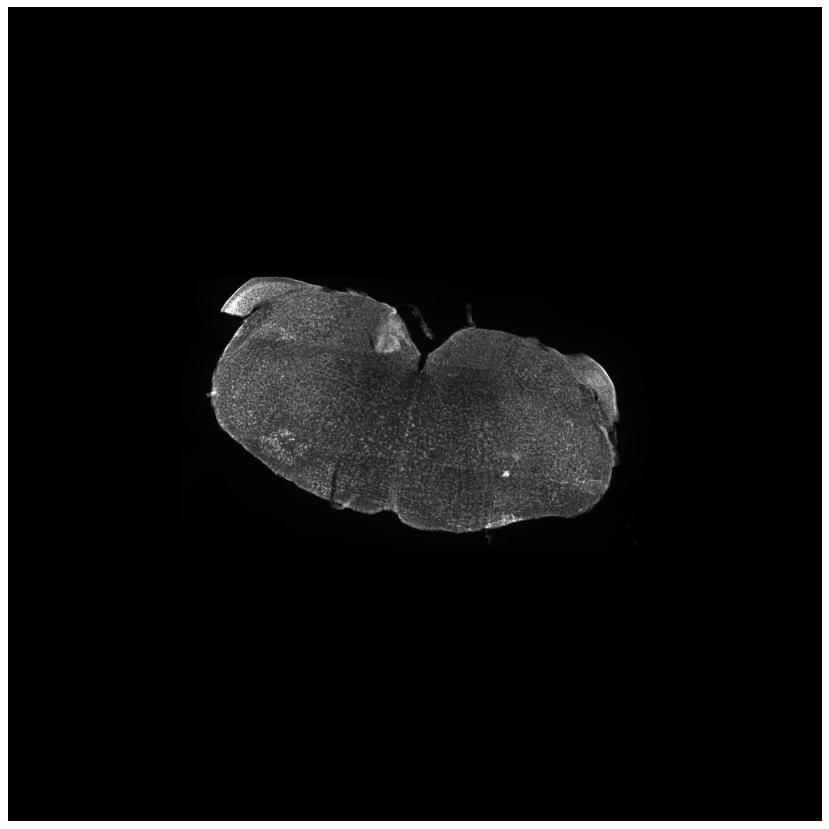

In [18]:
image = dataset.load_image(95)
results = model.detect([image], verbose=1)
plt.figure(figsize=(20,20))

r = results[0]
print(r['rois'])
print(r['class_ids'])
print(dataset.class_names)

visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], figsize=(15, 15), colors=colors)#ax=get_ax()

## Download detection masks

In [ ]:
from PIL import Image

# Create dir for detection masks
resetDataDir()
detection_mask_dir = 'detection_masks'
if (not os.path.isdir(detection_mask_dir)):
    os.mkdir(detection_mask_dir)

# Create id class map
class_map = {}
for info in dataset.class_info[1:]:
    class_map[int(info['id'])] = info['name']

# Download masks
for image_id in dataset.image_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    
    # Reset data directory to directory with detection masks
    resetDataDir()
    os.chdir('detection_masks')

    # Download detection masks
    section_detection_mask_dir = "section_masks_" + str(image_id)
    if (not os.path.isdir(section_detection_mask_dir)):
        os.mkdir(section_detection_mask_dir)
    os.chdir(section_detection_mask_dir)
    num_classes = np.shape(r['masks'])[2]
    for class_id in range(1,num_classes+1):
        im = Image.fromarray(np.uint8(r['masks'][:,:,class_id-1] * 255) , 'L')
        im.save("section_masks_" + str(image_id) + "_" + class_map[class_id] + "_m_" + str(class_id) + ".png")